# Local Spatial Autocorrelation

In [1]:
import geopandas

/tmp/ipykernel_1500521/1529612126.py:1: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas


In [2]:
gdf = geopandas.read_parquet('repub_lean.parquet')

<AxesSubplot:>

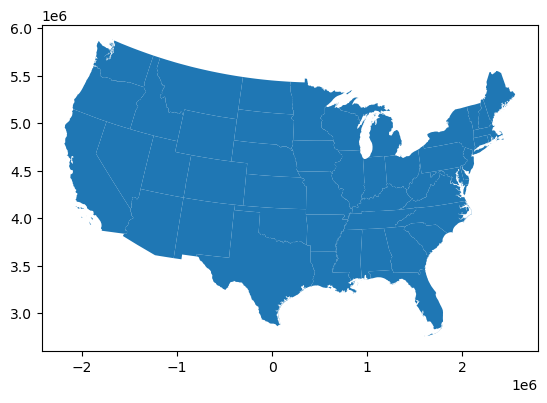

In [3]:
gdf.plot()

<AxesSubplot:>

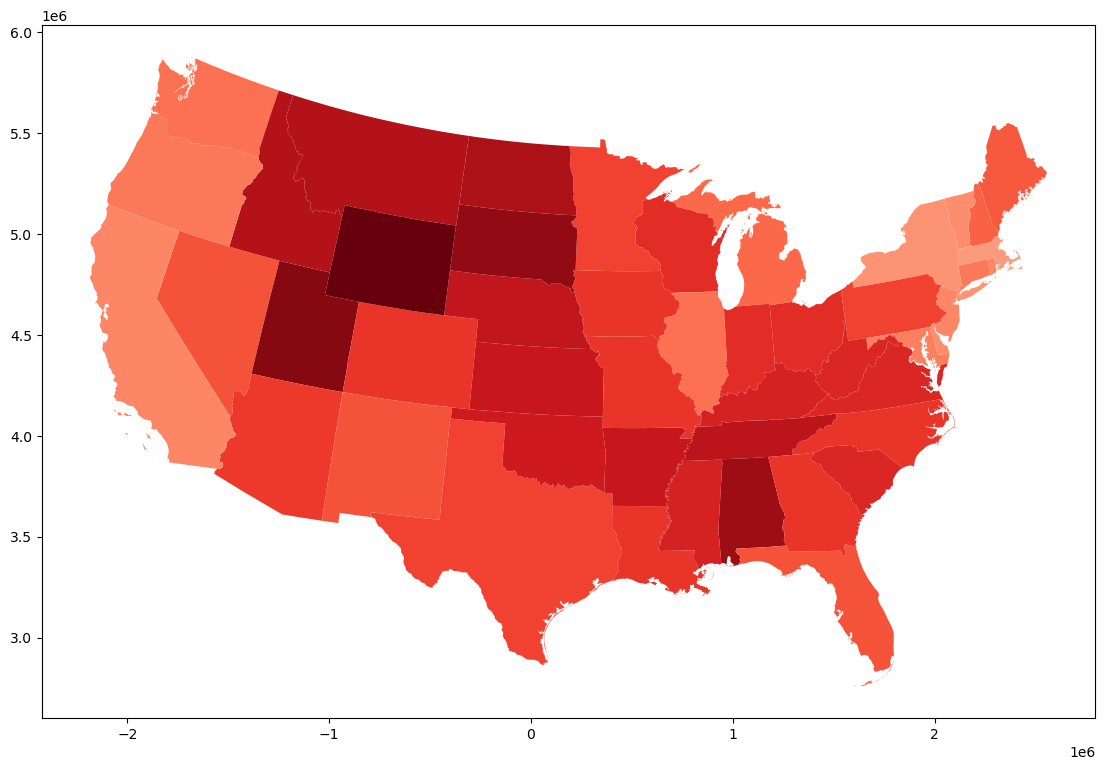

In [4]:
gdf.plot(column='rep_int', cmap='Reds', figsize=(16,9))

In [5]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Spatial Lag Leaning Republican')

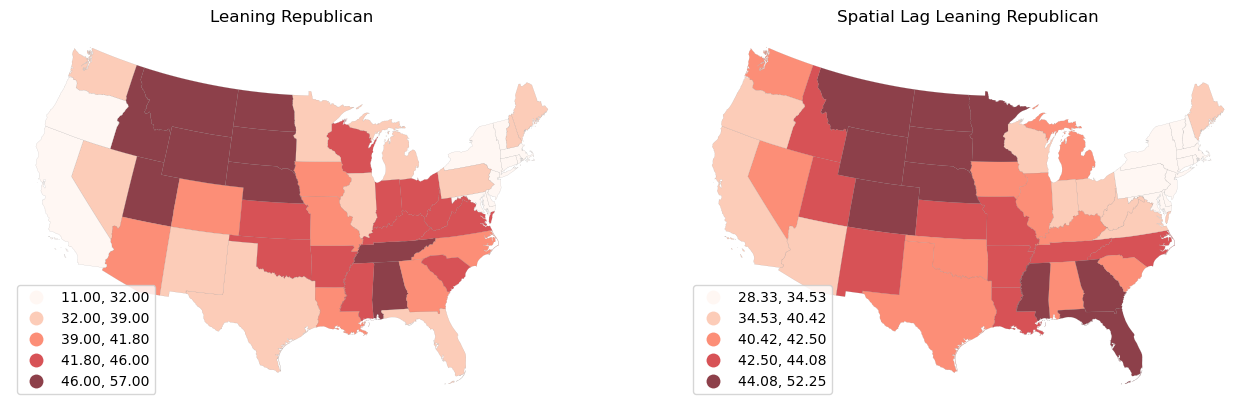

In [6]:
f, axs = plt.subplots(1, 2, figsize=(16, 9))
ax1, ax2 = axs



gdf.plot(column='rep_int',
         cmap='Reds',
         scheme='quantiles',
         k=5,
         edgecolor='grey',
         linewidth=0.1,
         alpha=0.75,
         legend=True,
         legend_kwds={'loc': 'lower left'},
         ax =ax1,
        )
ax1.set_axis_off()
ax1.set_title("Leaning Republican")


gdf.plot(column='lag_rep_int',
         cmap='Reds',
         scheme='quantiles',
         k=5,
         edgecolor='grey',
         linewidth=0.1,
         alpha=0.75,
         legend=True,
         legend_kwds={'loc': 'lower left'},
         ax =ax2,
        )
ax2.set_axis_off()
ax2.set_title("Spatial Lag Leaning Republican")

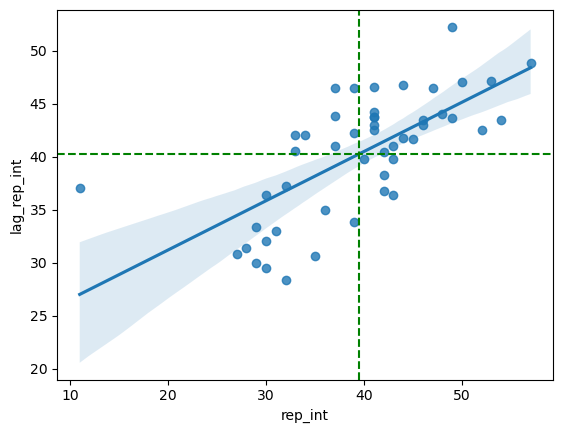

In [7]:
import seaborn as sns
_ = sns.regplot(x='rep_int', y='lag_rep_int', data=gdf)
plt.axhline(y=gdf.lag_rep_int.mean(), color='g', linestyle='--')
plt.axvline(x=gdf.rep_int.mean(), color='g', linestyle='--')

In [8]:
gdf.head()

,index,GEO_ID,STATE,state,LSAD,CENSUSAREA,geometry,Rep,No lean,Democrat/lean Dem.,Sample\tsize,rep_int,queen_neighbors,lag_rep_int
0,0,0400000US23,23,Maine,,30842.923,"MULTIPOLYGON (((2516172.424 5253443.650, 25164...",36%,17%,47%,303,36,1,35.00
1,1,0400000US25,25,Massachusetts,,7800.058,"MULTIPOLYGON (((2351724.597 4850457.653, 23526...",27%,17%,56%,704,27,5,30.80
2,2,0400000US26,26,Michigan,,56538.901,"MULTIPOLYGON (((821167.988 5338182.388, 821794...",34%,19%,47%,982,34,3,42.00
3,3,0400000US30,30,Montana,,145545.801,"POLYGON ((-371533.418 5042503.702, -386687.255...",49%,21%,30%,312,49,4,52.25
4,4,0400000US32,32,Nevada,,109781.180,"POLYGON ((-1384104.733 4308747.816, -1385163.9...",37%,18%,46%,314,37,5,41.00


In [9]:
y = gdf.rep_int
ylag = gdf.lag_rep_int

yh = y > y.mean()
ylh = ylag > ylag.mean()

In [10]:
q = 1 * yh * ylh + (2 * (1-yh) * ylh) + (3 * (1-yh) * (1-ylh))
q[q==0] = 4

In [11]:
gdf['q'] = q

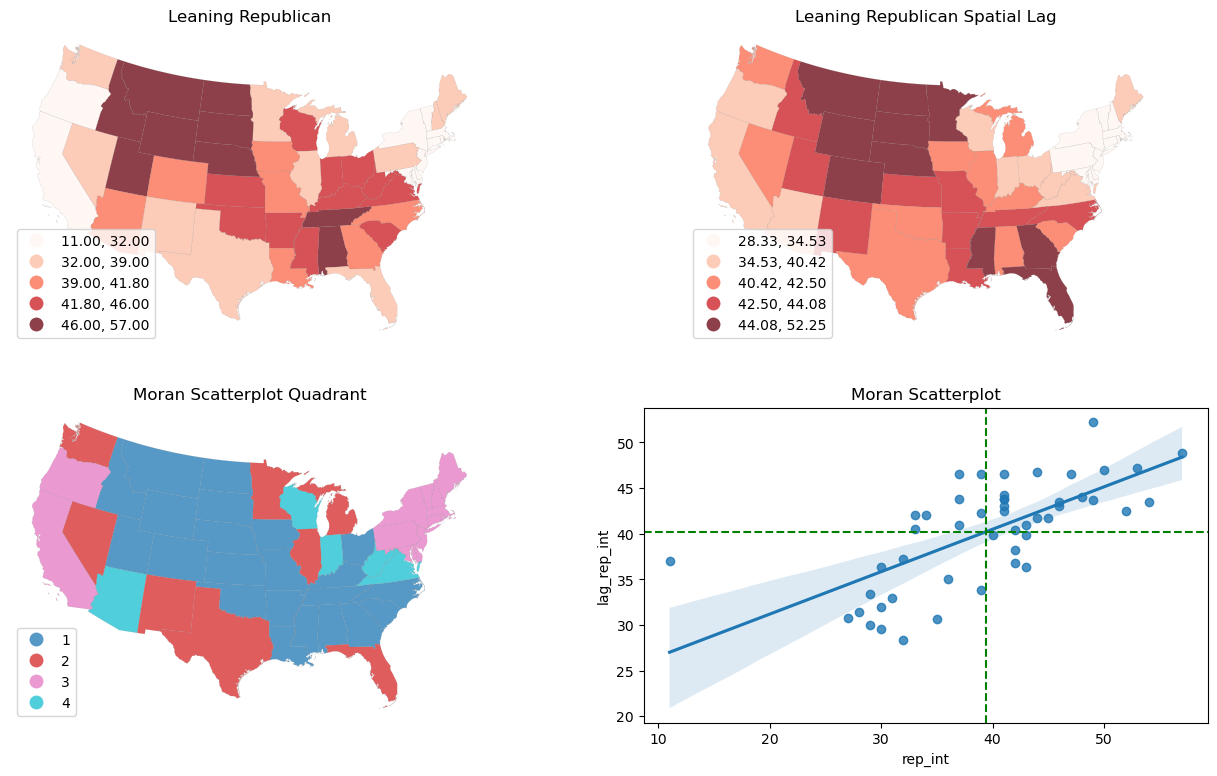

In [12]:
f, axs = plt.subplots(2,2, figsize=(16, 9))
ax1 = axs[0,0]
ax2 = axs[0,1]
ax3 = axs[1,0]
ax4 = axs[1,1]


gdf.plot(column='rep_int',
         cmap='Reds',
         scheme='quantiles',
         k=5,
         edgecolor='grey',
         linewidth=0.1,
         alpha=0.75,
         legend=True,
         legend_kwds={'loc': 'lower left'},
         ax =ax1,
        )
ax1.set_axis_off()
ax1.set_title("Leaning Republican")


gdf.plot(column='lag_rep_int',
         cmap='Reds',
         scheme='quantiles',
         k=5,
         edgecolor='grey',
         linewidth=0.1,
         alpha=0.75,
         legend=True,
         legend_kwds={'loc': 'lower left'},
         ax =ax2,
        )
ax2.set_axis_off()
ax2.set_title("Leaning Republican Spatial Lag")


gdf.plot(column='q',
         categorical=True,
         edgecolor='grey',
         linewidth=0.1,
         alpha=0.75,
         legend=True,
         legend_kwds={'loc': 'lower left'},
         ax =ax3,
        )
ax3.set_axis_off()
_= ax3.set_title("Moran Scatterplot Quadrant")


_ = sns.regplot(x='rep_int', y='lag_rep_int', data=gdf, ax=ax4)
plt.axhline(y=gdf.lag_rep_int.mean(), color='g', linestyle='--')
plt.axvline(x=gdf.rep_int.mean(), color='g', linestyle='--')
_= ax4.set_title("Moran Scatterplot")



## Moran's I

$$
I = \frac{n}{\sum_i \sum_j w_{i,j}} \frac{\sum_i \sum_j w_{i,j} z_i z_j} {\sum_i z_i^2}
$$
where $n$ is the number of observations, $z_i = y_i - \bar{y}$, and $w_{i,j}$ is the cell corresponding to the $i$-th row and $j$-th column of the spatial weights matrix.

In [13]:
from esda.moran import Moran
import libpysal

/opt/tljh/user/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
/opt/tljh/user/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:165: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_faces(triangle):
/opt/tljh/user/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:199: N

In [14]:
y = gdf.rep_int
w = libpysal.weights.Queen.from_dataframe(gdf)

In [15]:
 
mi = Moran(y, w)

In [16]:
mi.EI

-0.020833333333333332

In [17]:
mi.EI_sim

-0.017173754335507878

In [18]:
mi.p_sim

0.001

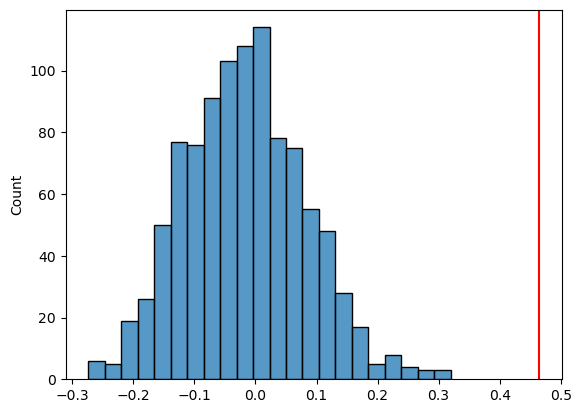

In [19]:
import seaborn
ax = seaborn.histplot(mi.sim)
_ = plt.axvline(mi.I, 0, 100, color='r')

## Local Moran

In [20]:
from esda.moran import Moran_Local

$$
I_i = \frac{\sum_j w_{i,j}z_i z_j}{\sum_i z_i^2}= \frac{z_i}{\sum_i z_i^2} \sum_j w_{i,j} z_j
$$
where $n$ is the number of observations, $z_i = y_i - \bar{y}$, and $w_{i,j}$ is the cell corresponding to the $i$-th row and $j$-th column of the spatial weights matrix.

In [21]:
lmi = Moran_Local(y, w)

In [22]:
import seaborn

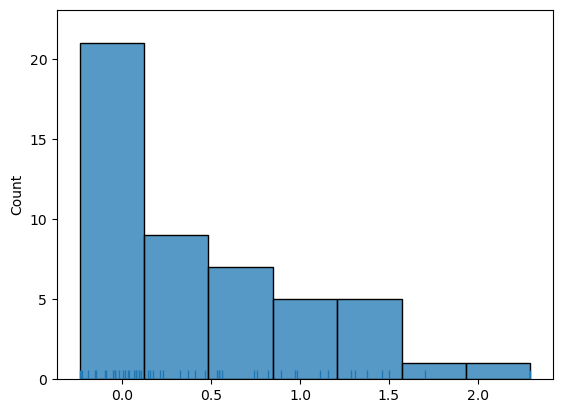

In [23]:
ax = seaborn.histplot(lmi.Is)
# Add one small bar (rug) for each observation
# along horizontal axis
seaborn.rugplot(lmi.Is, ax=ax);

In [24]:
from splot import esda as esdaplot
import pandas

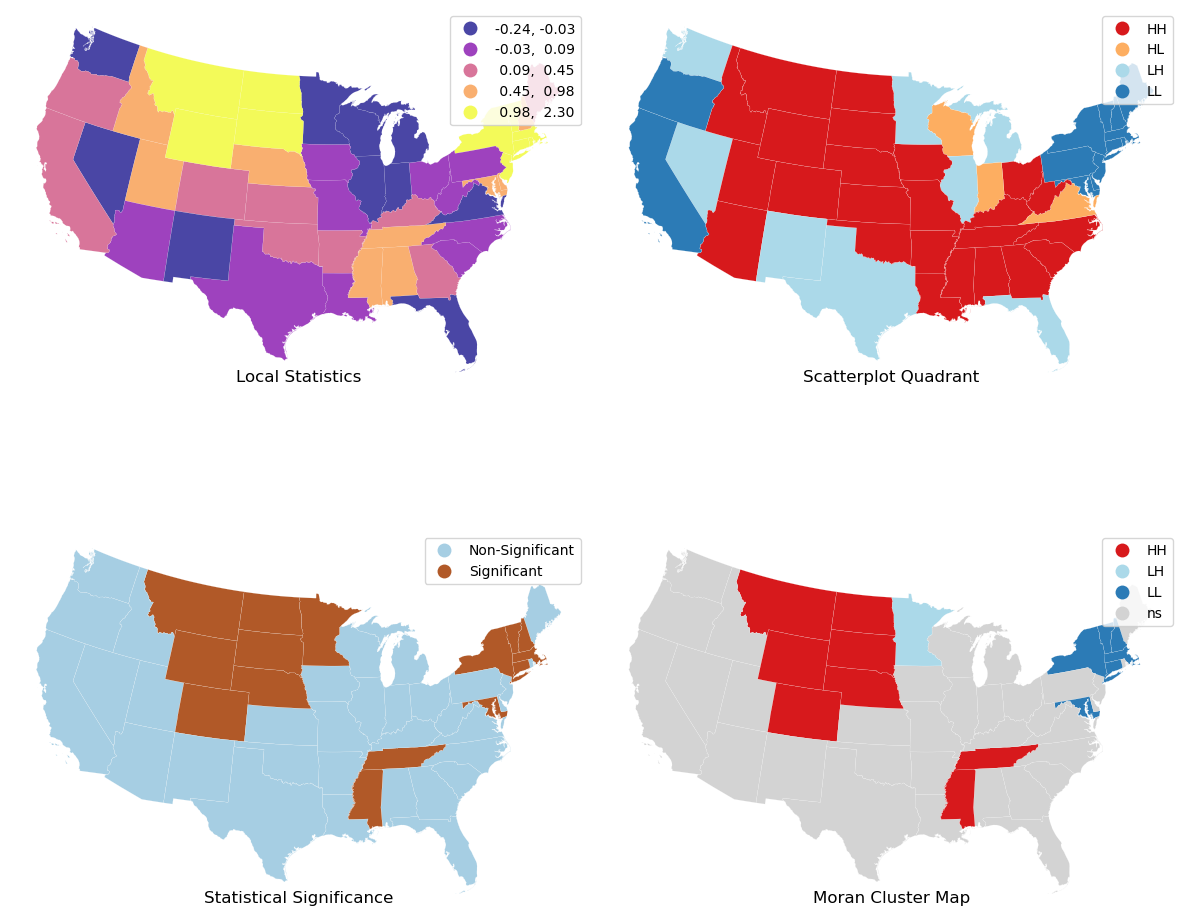

In [25]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()
db = gdf
lisa = lmi
# Subplot 1 #
# Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# Assign new column with local statistics on-the-fly
db.assign(
    Is=lmi.Is
    # Plot choropleth of local statistics
).plot(
    column="Is",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax,
)

# Subplot 2 #
# Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# Plot Quadrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa, db, p=1, ax=ax)

# Subplot 3 #
# Significance map
# Grab third axis of local statistics
ax = axs[2]
#
# Find out significant observations
labels = pandas.Series(
    1 * (lisa.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=db.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})
# Assign labels to `db` on the fly
db.assign(
    cl=labels
    # Plot choropleth of (non-)significant areas
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax,
)


# Subplot 4 #
# Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quadrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa, db, p=0.05, ax=ax)

# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
        y=0,
    )
# Tight layout to minimize in-between white space
f.tight_layout()

# Display the figure
plt.show()

In [26]:
dir(lmi)

['EI',
 'EI_sim',
 'EIc',
 'Is',
 'VI',
 'VI_sim',
 'VIc',
 '_Moran_Local__calc',
 '_Moran_Local__moments',
 '_Moran_Local__quads',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_statistic',
 'by_col',
 'den',
 'geoda_quads',
 'n',
 'n_1',
 'p_sim',
 'p_z_sim',
 'permutations',
 'q',
 'quads',
 'rlisas',
 'seI_sim',
 'sim',
 'w',
 'y',
 'z',
 'z_sim']

In [27]:
lmi.sim.shape

(999, 49)

In [28]:
idxs = lmi.p_sim < 0.05

In [29]:
idxs

array([False,  True, False,  True, False, False,  True, False, False,
       False, False,  True, False, False, False, False,  True, False,
       False, False, False,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
       False,  True,  True, False,  True, False, False, False,  True,
        True, False, False,  True])

In [31]:
idx = 1 # the second observation has a significant LISA

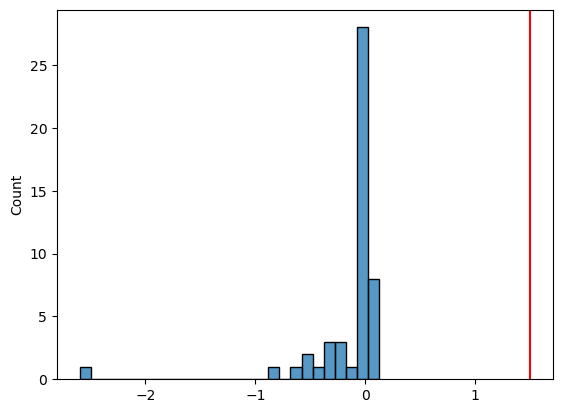

In [32]:
ax = seaborn.histplot(lmi.sim[idx])
_ = plt.axvline(lmi.Is[idx], 0, 100, color='r')

In [33]:
idx = 0 # the first observation does not have a significant lisa

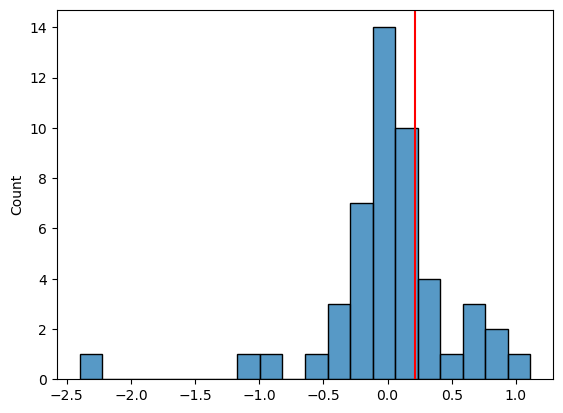

In [34]:
ax = seaborn.histplot(lmi.sim[idx])
_ = plt.axvline(lmi.Is[idx], 0, 100, color='r')